In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.ticker import FuncFormatter
from matplotlib import rcParams
import diptest

rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],  # matches Overleaf lmodern
    "mathtext.fontset": "cm",
    "text.latex.preamble": r"\usepackage{lmodern}\usepackage{amsmath}"
})

pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 14)

# Load Data

## Load Translated 'Critic Review' Data, check Columns and DTypes

In [3]:
critic_reviews = pd.concat([pd.read_json(f"Rotten Tomatoes Reviews/Critic Reviews Translated/rt_critic_reviews_translated_{i}.json") for i in range(10)])
critic_reviews["creationDate"] = pd.to_datetime(critic_reviews["creationDate"])
critic_reviews["language"] = pd.Categorical(critic_reviews["language"])
critic_reviews["id"] = pd.Categorical(critic_reviews["id"])
print(critic_reviews.head())
critic_reviews.dtypes

         id   reviewId creationDate      criticName                                         reviewText                                     originalReview language  ratingOutOfTen originalRating reviewState        title
0  10000_bc  102712136   2022-07-25     James Croot  Prehistoric compared to 1966's One Million BC,...  Prehistoric compared to 1966's One Million BC,...       en            2.00            1/5      rotten  10,000 B.C.
1  10000_bc  102673586   2022-03-29   Matthew Rozsa  It is a solidly good movie, a sincere Valentin...  It is a solidly good movie, a sincere Valentin...       en            7.50            3/4       fresh  10,000 B.C.
2  10000_bc    2746017   2020-11-28     Mike Massie  Rather than storytelling, it thrives on its CG...  Rather than storytelling, it thrives on its CG...       en            3.00           3/10      rotten  10,000 B.C.
3  10000_bc    2739755   2020-11-04  Carlos Marañón  Those stampeding mammoths... [are] the jewel o...  Those stampeding mam

id                      category
reviewId                   int64
creationDate      datetime64[ns]
criticName                object
reviewText                object
originalReview            object
language                category
ratingOutOfTen           float64
originalRating            object
reviewState               object
title                     object
dtype: object

## Load already cleaned 'Movie' Dataset

In [4]:
movies = pd.read_json("Rotten Tomatoes Reviews/rt_movies_clean.json")
movies["id"] = pd.Categorical(movies["id"])
movies["releaseDateStreaming"] = pd.to_datetime(movies["releaseDateStreaming"], errors="coerce")
movies["releaseDateTheaters"] = pd.to_datetime(movies["releaseDateTheaters"], errors="coerce")
movies["originalLanguage"] = pd.Categorical(movies["originalLanguage"])

print(movies.head())
print("\n", movies.dtypes)

                       id                     title  audienceScore  tomatoMeter ageRating                                     ratingContents releaseDateTheaters releaseDateStreaming  runtimeMinutes                        genre originalLanguage                        director  releaseYear  \
0             adrift_2018                    Adrift           65.0         69.0     PG-13  [Injury Images, Brief Drug Use, Thematic Eleme...          2018-06-01           2018-08-21           120.0  [Adventure, Drama, Romance]          English               Baltasar Kormákur       2018.0   
1  sarah_palin_you_betcha  Sarah Palin: You Betcha!           61.0         32.0      None                                                 []          2011-09-30           2017-03-08            90.0                [Documentary]          English  Nick Broomfield,Joan Churchill       2011.0   
2    a_state_of_mind_2005           A State of Mind           92.0         89.0      None                                   

# Clean Translated 'Audience Reviews' Dataset

## Locate and Drop Reviews with Non-Verbal Review Text ('language' = unknown)

In [5]:
print(f"Number of reviews with non-verbal review texts:", critic_reviews[critic_reviews["language"] == "unknown"].shape[0])
critic_reviews.drop(critic_reviews[critic_reviews["language"] == "unknown"].index, inplace=True)
critic_reviews.reset_index(inplace=True, drop=True)

Number of reviews with non-verbal review texts: 64


## Locate and Drop Reviews that Experienced Errors in the Translation Process ('reviewText' = None)

In [6]:
print("Reviews dropped due to failed translation:", critic_reviews[critic_reviews["reviewText"].isna()].shape[0])
critic_reviews.drop(critic_reviews[critic_reviews["reviewText"].isna()].index, inplace=True)
critic_reviews.reset_index(inplace=True, drop=True)

Reviews dropped due to failed translation: 0


## Create Column Containing the Length of the Review

In [7]:
critic_reviews["reviewLength"] = critic_reviews["originalReview"].str.len()

## Save Clean 'Critic Reviews' Dataset

In [8]:
folder = Path("Rotten Tomatoes Reviews/Critic Reviews Clean")
folder.mkdir(parents=True, exist_ok=True)

n_batches = 20

# Group by id, so all reviews concerning the same movie are in the same batch
groups = [g for _, g in critic_reviews.groupby("id")]

# Initialize List for allocation and list of batch size to get an even split
chunks = [[] for _ in range(n_batches)]
sizes = [0] * n_batches

# Always assign the reviews concerning to the movie to the currently smallest batch
for g in groups:
    idx = np.argmin(sizes)
    chunks[idx].append(g)
    sizes[idx] += len(g)

# Save each batch as JSON
for i, chunk in enumerate(chunks):
    output_path = folder / f"rt_critic_reviews_clean_{i}.json"

    batch = pd.concat(chunk, ignore_index=True)

    batch.to_json(output_path, date_format="iso", orient="records", indent=2)
    print(f"Batch {i} saved with {len(batch)} reviews")

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/2134142140.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g for _, g in critic_reviews.groupby("id")]


Batch 0 saved with 46963 reviews
Batch 1 saved with 46776 reviews
Batch 2 saved with 46784 reviews
Batch 3 saved with 46785 reviews
Batch 4 saved with 46775 reviews
Batch 5 saved with 46843 reviews
Batch 6 saved with 46958 reviews
Batch 7 saved with 46792 reviews
Batch 8 saved with 46956 reviews
Batch 9 saved with 46728 reviews
Batch 10 saved with 46784 reviews
Batch 11 saved with 46951 reviews
Batch 12 saved with 46740 reviews
Batch 13 saved with 46729 reviews
Batch 14 saved with 46850 reviews
Batch 15 saved with 46756 reviews
Batch 16 saved with 46727 reviews
Batch 17 saved with 46753 reviews
Batch 18 saved with 46738 reviews
Batch 19 saved with 46961 reviews


# Merge 'Critic Reviews' with 'Movie' Dataset

In [9]:
Working_Critic_Data = critic_reviews.merge(right=movies, how="left", on="id")
print(Working_Critic_Data[["id", "reviewId", "creationDate", "criticName", "reviewText", "language", "ratingOutOfTen", "reviewLength", "genre", "releaseYear", "boxOffice"]].head())
Working_Critic_Data.dtypes

         id   reviewId creationDate      criticName                                         reviewText language  ratingOutOfTen  reviewLength                       genre  releaseYear   boxOffice
0  10000_bc  102712136   2022-07-25     James Croot  Prehistoric compared to 1966's One Million BC,...       en            2.00           125  [Adventure, Action, Drama]       2008.0  94800000.0
1  10000_bc  102673586   2022-03-29   Matthew Rozsa  It is a solidly good movie, a sincere Valentin...       en            7.50            86  [Adventure, Action, Drama]       2008.0  94800000.0
2  10000_bc    2746017   2020-11-28     Mike Massie  Rather than storytelling, it thrives on its CG...       en            3.00            55  [Adventure, Action, Drama]       2008.0  94800000.0
3  10000_bc    2739755   2020-11-04  Carlos Marañón  Those stampeding mammoths... [are] the jewel o...       en            6.00            98  [Adventure, Action, Drama]       2008.0  94800000.0
4  10000_bc    2728583   

id                            category
reviewId                         int64
creationDate            datetime64[ns]
criticName                      object
reviewText                      object
originalReview                  object
language                      category
ratingOutOfTen                 float64
originalRating                  object
reviewState                     object
title_x                         object
reviewLength                     int64
title_y                         object
audienceScore                  float64
tomatoMeter                    float64
ageRating                       object
ratingContents                  object
releaseDateTheaters     datetime64[ns]
releaseDateStreaming    datetime64[ns]
runtimeMinutes                 float64
genre                           object
originalLanguage              category
director                        object
releaseYear                    float64
boxOffice                      float64
dtype: object

# Descriptive Statistics 'Critic Reviews' after Cleaning

In [10]:
critic_reviews.describe(include="all")

,id,reviewId,creationDate,criticName,reviewText,originalReview,language,ratingOutOfTen,originalRating,reviewState,title,reviewLength
count,936349,9.363490e+05,936349,931840,936349,936349,936349,552980.000000,674326,936349,936349,936349.000000
unique,9116,NaN,NaN,12003,933978,933983,31,NaN,1359,2,8947,NaN
top,joker_2019,NaN,NaN,Frank Swietek,Parental Content Review,Parental Content Review,en,NaN,4/5,fresh,Beauty and the Beast,NaN
freq,608,NaN,NaN,4918,229,229,924463,NaN,67492,616557,647,NaN
mean,NaN,8.857994e+06,2012-10-31 14:18:00.650911232,NaN,NaN,NaN,NaN,6.439966,NaN,NaN,NaN,131.738752
min,NaN,1.000000e+00,1998-08-14 00:00:00,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,5.000000
25%,NaN,1.607898e+06,2007-03-17 00:00:00,NaN,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,89.000000
50%,NaN,2.150200e+06,2013-06-27 00:00:00,NaN,NaN,NaN,NaN,6.250000,NaN,NaN,NaN,130.000000
75%,NaN,2.511236e+06,2018-09-18 00:00:00,NaN,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,171.000000
max,NaN,1.030419e+08,2025-08-02 00:00:00,NaN,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,363.000000


## Movie / Review Stats

In [11]:
print("Number of Critic Reviews:", Working_Critic_Data.shape[0])
print("Number of Movies:", Working_Critic_Data["id"].value_counts().describe()["count"])
print("Distribution Characteristics of Reviews per Movie:\n", Working_Critic_Data["id"].value_counts().describe()[["mean", "std", "min", "25%","50%","75%", "max"]])

Number of Critic Reviews: 936349
Number of Movies: 9116.0
Distribution Characteristics of Reviews per Movie:
 mean    102.714897
std      81.762729
min      19.000000
25%      41.000000
50%      78.000000
75%     139.000000
max     608.000000
Name: count, dtype: float64


## Observations with non-Numerical and missing Ratings

In [12]:
print("Number of Observations with non-Numerical Ratings:", Working_Critic_Data[(np.isnan(Working_Critic_Data["ratingOutOfTen"])) & (~pd.isnull(Working_Critic_Data["originalRating"]))].shape[0])
print("Number of Observations with missing Ratings:", Working_Critic_Data[(np.isnan(Working_Critic_Data["ratingOutOfTen"])) & (pd.isnull(Working_Critic_Data["originalRating"]))].shape[0])

Number of Observations with non-Numerical Ratings: 121346
Number of Observations with missing Ratings: 262023


## Inconsistent Ratings (Ratings >= 8 with a Review State of "rotten" and Ratings <= 3 with a Review State of "fresh")

In [13]:
print("Number of reviews with inconsistent ratings:", Working_Critic_Data.loc[((Working_Critic_Data["ratingOutOfTen"] >= 7) & (Working_Critic_Data["reviewState"] == "rotten")) | ((Working_Critic_Data["ratingOutOfTen"] <= 3) & (Working_Critic_Data["reviewState"] == "fresh"))].shape[0])

Number of reviews with inconsistent ratings: 997


## Review Languages

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/663383487.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topTenRevLanguages = Working_Critic_Data.groupby("language").agg(Languages = ("language", "first"),
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/663383487.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  table = ax[0].table(cellText=topTenRevLanguages.applymap(lambda x: f"{x:,}".replace(",", "'") if isinstance(x, int) else f"{x}%" if isinstance(x, float) else x).values,


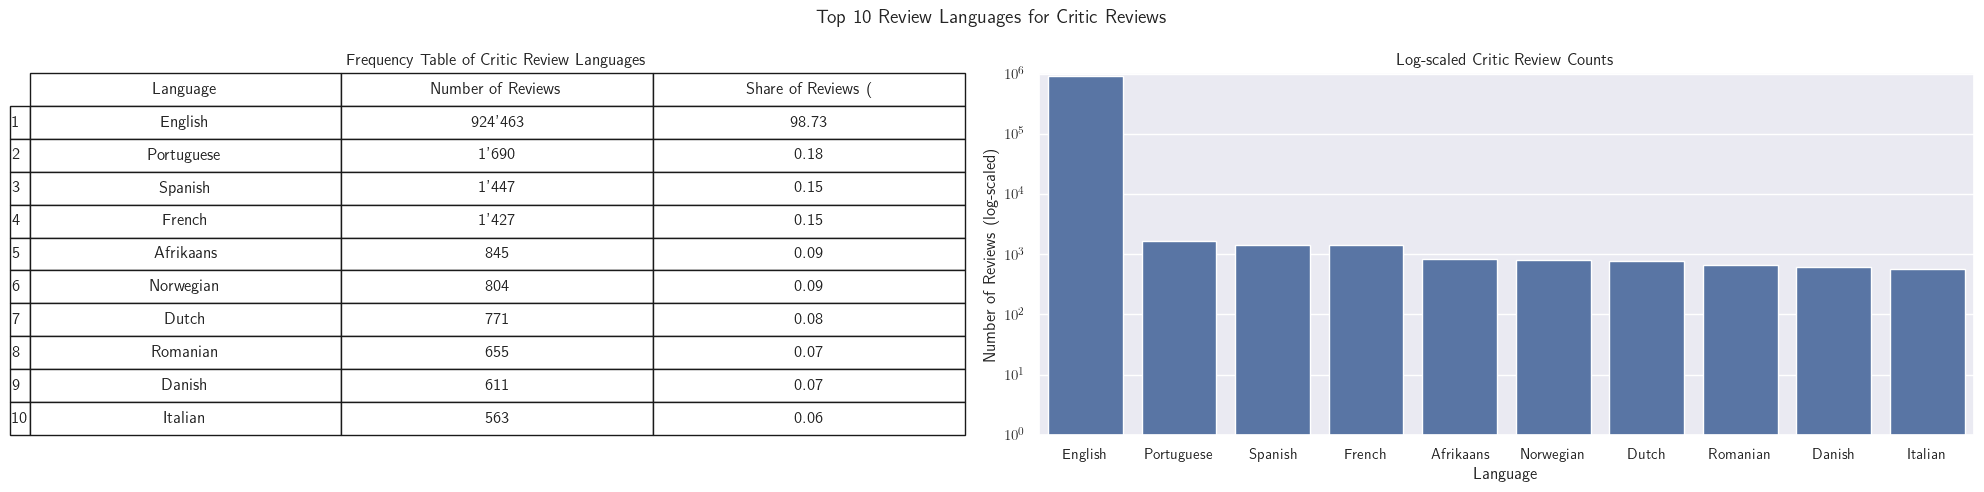

In [14]:
topTenRevLanguages = Working_Critic_Data.groupby("language").agg(Languages = ("language", "first"),
                                              NumReviews = ("language", "count")).sort_values("NumReviews", ascending=False).reset_index(drop=True)[0:10]
totalReviews = Working_Critic_Data.shape[0]

lang_map = {"en": "English",
            "es": "Spanish",
            "pt": "Portuguese",
            "fr": "French",
            "af": "Afrikaans",
            "it": "Italian",
            "no": "Norwegian",
            "nl": "Dutch",
            "ro": "Romanian",
            "da": "Danish"}

colLabels = {"Languages": "Language", "NumReviews": "Number of Reviews", "ShareOfTotal": "Share of Reviews (%)"}

topTenRevLanguages["Languages"] = topTenRevLanguages["Languages"].map(lang_map)
topTenRevLanguages["ShareOfTotal"] = round(topTenRevLanguages["NumReviews"]/totalReviews*100, ndigits=2)


sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (20, 5))
fig.suptitle("Top 10 Review Languages for Critic Reviews", fontweight="bold", fontsize=14)

ax[0].axis("off")
table = ax[0].table(cellText=topTenRevLanguages.applymap(lambda x: f"{x:,}".replace(",", "'") if isinstance(x, int) else f"{x}%" if isinstance(x, float) else x).values,
                  rowLabels=topTenRevLanguages.index + 1,
                  colLabels=[colLabels.get(c,c) for c in topTenRevLanguages.columns],
                  cellLoc = "center",
                  loc = "center")

ax[0].set_title("Frequency Table of Critic Review Languages", fontsize=12)
table.scale(1, 2.1)

sns.barplot(topTenRevLanguages, x="Languages", y="NumReviews", ax=ax[1])
ax[1].set_yscale("log")
ax[1].set_ylim(1, topTenRevLanguages["NumReviews"].max()*1.1)

ax[1].set_title("Log-scaled Critic Review Counts", fontsize=12)
ax[1].set_xlabel("Language")
ax[1].set_ylabel("Number of Reviews (log-scaled)")

plt.tight_layout()
plt.show()

## TimeSeries of Reviews Written

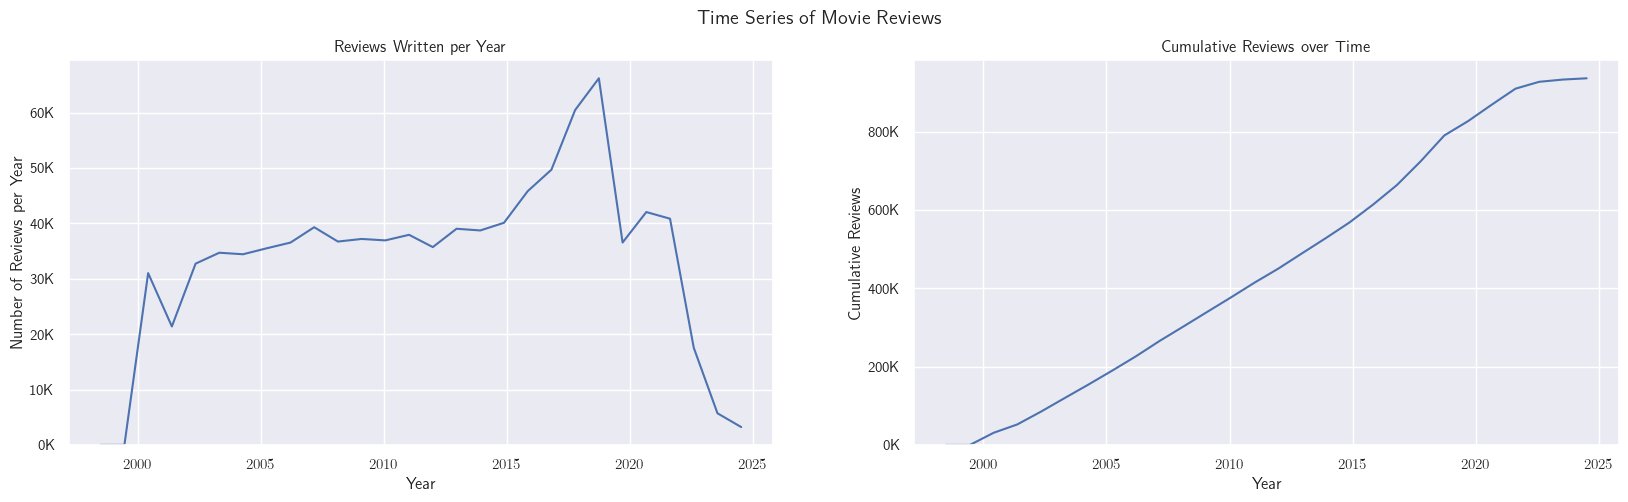

In [15]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (20, 5), sharex=True)
fig.suptitle("Time Series of Movie Reviews", fontweight = "bold")

sns.histplot(Working_Critic_Data["creationDate"].dt.year, bins = 28, element="poly", fill=False, ax=ax[0])
ax[0].set_title("Reviews Written per Year")
ax[0].set_ylabel("Number of Reviews per Year")
ax[0].set_xlabel("Year")
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000):,}K".replace(",", "'")))

sns.histplot(Working_Critic_Data["creationDate"].dt.year, bins = 28, element="poly", fill=False, cumulative=True, ax=ax[1])
ax[1].set_title("Cumulative Reviews over Time")
ax[1].set_ylabel("Cumulative Reviews")
ax[1].set_xlabel("Year")
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000):,}K".replace(",", "'")))

plt.show()

## Variable Distributions

### Distribution of Movie Ratings

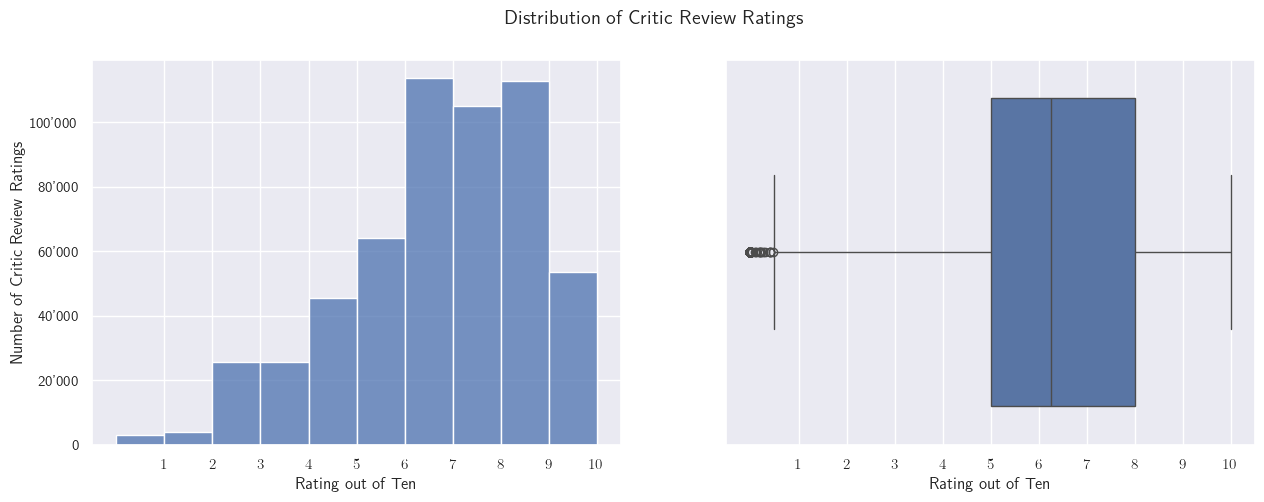

count    552980.000000
mean          6.439966
std           2.067837
min           0.000000
25%           5.000000
50%           6.250000
75%           8.000000
max          10.000000
Name: ratingOutOfTen, dtype: float64

Testing H₀: The distribution of Critic Review Ratings is unimodal using Hartigan's Diptest 
Hartigan's dip statistic and p-value: 0.0, 1.0


Hartigan's dip statistic and p-value (calculated on a sample of 72'000): 0.0, 1.0



/Users/renatoromagna/Desktop/UZH/Masterarbeit/Master's Thesis Code/.venv/lib/python3.11/site-packages/diptest/consts.py:702: UserWarning: Sample size exceeds the maximum limit of 72000. Results may not be accurate with precomputed statistical values.
  warnings.warn(


In [16]:
fig, ax = plt.subplots(1,2,figsize = (15, 5), sharex=True)
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Critic Review Ratings", fontweight = "bold")

sns.histplot(Working_Critic_Data["ratingOutOfTen"], bins = 10, ax=ax[0])
ax[0].set_xticks(range(1,11))
ax[0].set_ylabel("Number of Critic Review Ratings")
ax[0].set_xlabel("Rating out of Ten")
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))

sns.boxplot(Working_Critic_Data["ratingOutOfTen"], orient="h", ax=ax[1])
ax[1].set_xticks(range(1,11))
ax[1].set_xlabel("Rating out of Ten")
plt.show()

print(Working_Critic_Data["ratingOutOfTen"].describe())

dip, pval = diptest.diptest(Working_Critic_Data["ratingOutOfTen"].values)
print(f"\nTesting H₀: The distribution of Critic Review Ratings is unimodal using Hartigan's Diptest",
      f"\nHartigan's dip statistic and p-value: {dip}, {pval}\n")

sample = np.random.choice(Working_Critic_Data["ratingOutOfTen"].values, size=72000, replace=False)
dip, pval = diptest.diptest(sample)

print(f"\nHartigan's dip statistic and p-value (calculated on a sample of 72'000): {dip}, {pval}\n")

### Distribution of Average Movie Ratings

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/3181492683.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.histplot(Working_Critic_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, bins = 21, ax=ax[0])
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/3181492683.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(Working_Critic_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, orient="h", ax=ax[1])


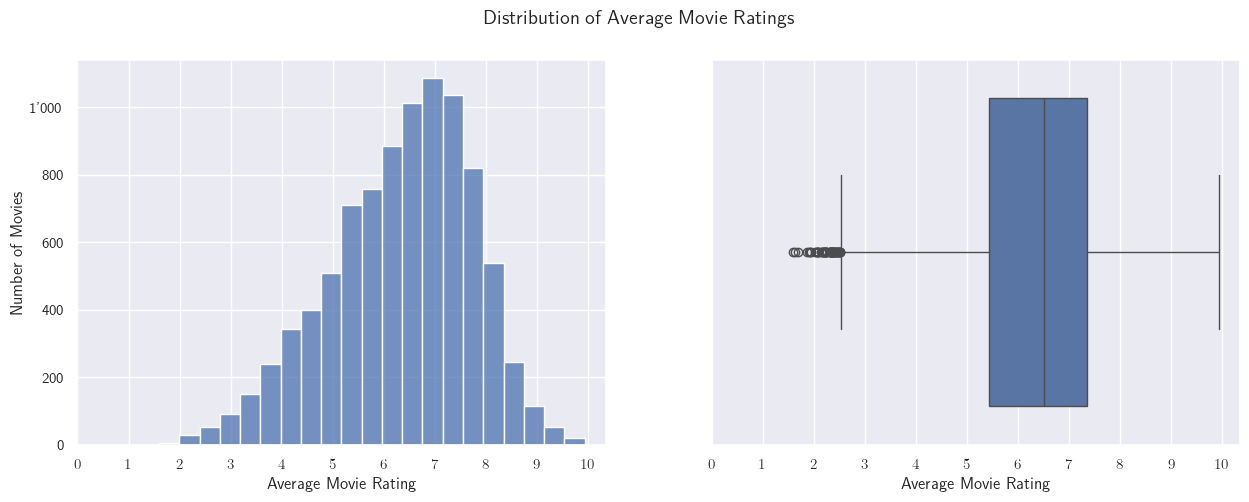

count    9116.000000
mean        6.336909
std         1.388709
min         1.598049
25%         5.424006
50%         6.506699
75%         7.357143
max         9.928571
Name: MovieRating, dtype: float64


/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/3181492683.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(Working_Critic_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].describe())


In [17]:
fig, ax = plt.subplots(1,2,figsize = (15, 5), sharex=True)
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Average Movie Ratings", fontweight="bold")

sns.histplot(Working_Critic_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, bins = 21, ax=ax[0])
ax[0].set_xticks(range(11))
ax[0].set_ylabel("Number of Movies")
ax[0].set_xlabel("Average Movie Rating")
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))

sns.boxplot(Working_Critic_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].values, orient="h", ax=ax[1])
ax[1].set_xticks(range(11))
ax[1].set_xlabel("Average Movie Rating")
plt.show()

print(Working_Critic_Data.groupby("id").agg(MovieRating = ("ratingOutOfTen", "mean"))["MovieRating"].describe())

### Distribution of the Number of Reviews per Movie

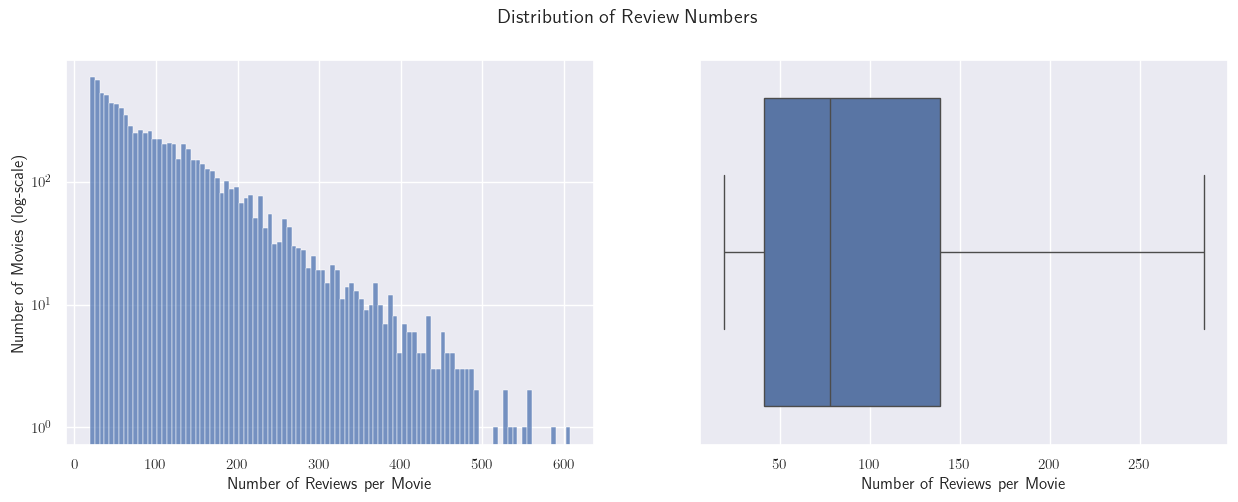

count    9116.000000
mean      102.714897
std        81.762729
min        19.000000
25%        41.000000
50%        78.000000
75%       139.000000
max       608.000000
Name: count, dtype: float64


In [18]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Review Numbers", fontweight = "bold")

sns.histplot(Working_Critic_Data["id"].value_counts(), bins = 100, ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of Reviews per Movie")
ax[0].set_ylabel("Number of Movies (log-scale)")

sns.boxplot(Working_Critic_Data["id"].value_counts(), orient="h", showfliers = False, ax=ax[1])
ax[1].set_xlabel("Number of Reviews per Movie")
plt.show()

print(Working_Critic_Data["id"].value_counts().describe())

### Distribution of the Number of Reviews per Critic

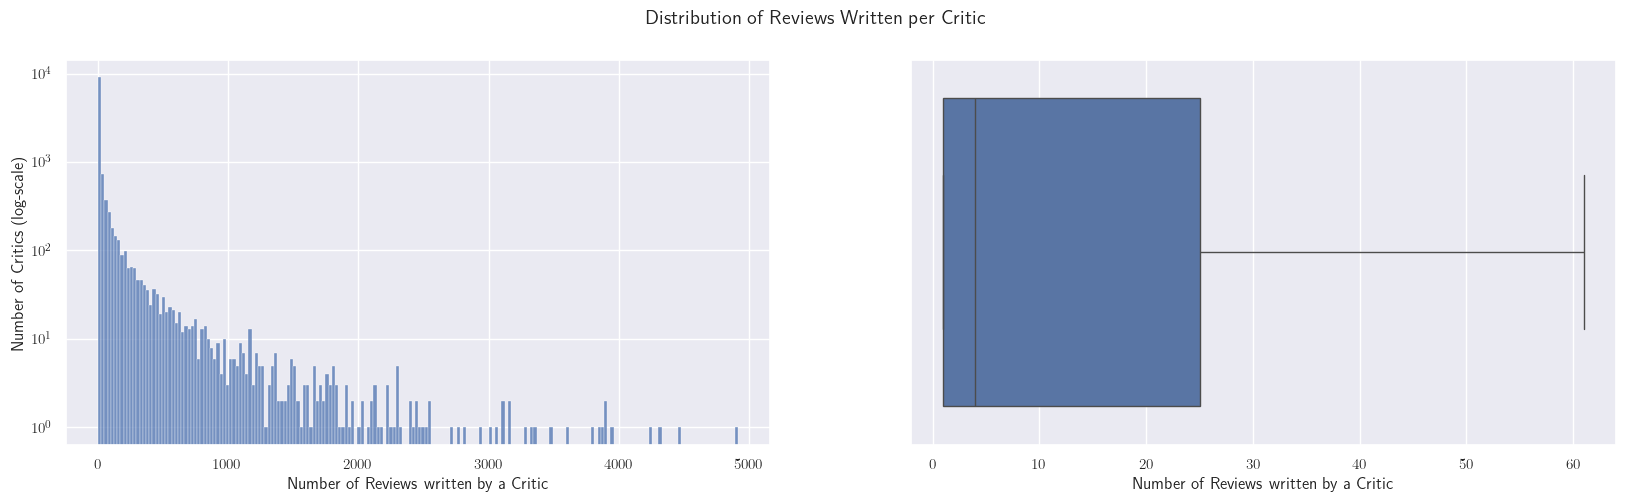

count    12003.000000
mean        77.633925
std        277.818938
min          1.000000
25%          1.000000
50%          4.000000
75%         25.000000
max       4918.000000
Name: count, dtype: float64


In [19]:
fig, ax = plt.subplots(1,2, figsize = (20, 5))
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Reviews Written per Critic", fontweight = "bold")

sns.histplot(Working_Critic_Data["criticName"].value_counts(), bins = 200, ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Number of Reviews written by a Critic")
ax[0].set_ylabel("Number of Critics (log-scale)")

sns.boxplot(Working_Critic_Data["criticName"].value_counts(), orient="h", showfliers=False, ax=ax[1])
ax[1].set_xlabel("Number of Reviews written by a Critic")
plt.show()

print(Working_Critic_Data["criticName"].value_counts().describe())


### Distribution of Review Text Length

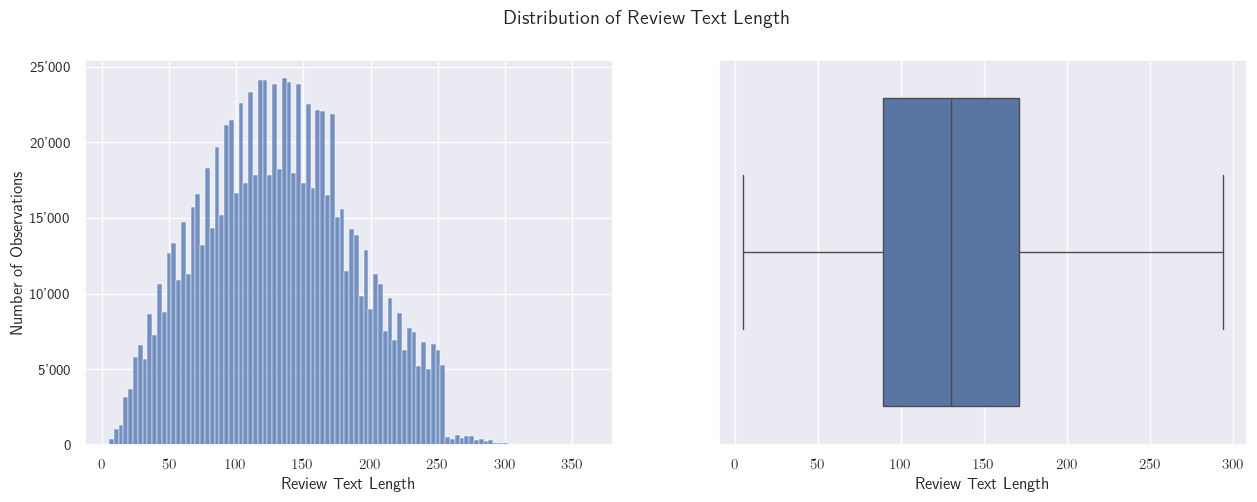

count    936349.000000
mean        131.738752
std          56.485461
min           5.000000
25%          89.000000
50%         130.000000
75%         171.000000
max         363.000000
Name: reviewLength, dtype: float64


In [20]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.set_theme(style="darkgrid")
fig.suptitle("Distribution of Review Text Length", fontweight = "bold")

sns.histplot(Working_Critic_Data["reviewLength"], bins = 100, ax=ax[0])
ax[0].set_xlabel("Review Text Length")
ax[0].set_ylabel("Number of Observations")
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))

sns.boxplot(Working_Critic_Data["reviewLength"], orient="h", showfliers=False, ax=ax[1])
ax[1].set_xlabel("Review Text Length")
plt.show()

print(Working_Critic_Data["reviewLength"].describe())

### Distribution of Movie Box Office

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/1349966943.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.histplot(Working_Critic_Data.groupby("id").head(1)["boxOffice"], bins = 100, ax=ax[0])
/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/1349966943.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.boxplot(Working_Critic_Data.groupby("id").head(1)["boxOffice"], orient="h", showfliers=False, ax=ax[1])


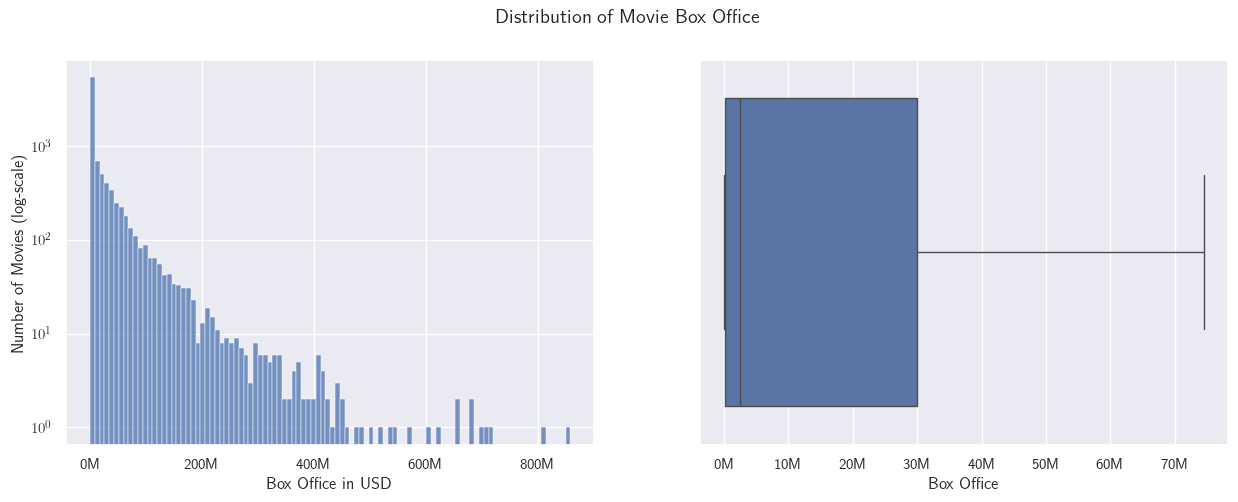

count    9.363490e+05
mean     5.147897e+07
std      9.123120e+07
min      3.690000e+02
25%      1.000000e+06
50%      1.590000e+07
75%      6.010000e+07
max      8.584000e+08
Name: boxOffice, dtype: float64


In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.set_theme(style="darkgrid")
plt.suptitle("Distribution of Movie Box Office", fontweight="bold")

sns.histplot(Working_Critic_Data.groupby("id").head(1)["boxOffice"], bins = 100, ax=ax[0])
ax[0].set_yscale("log")
ax[0].set_xlabel("Box Office in USD")
ax[0].set_ylabel("Number of Movies (log-scale)")
ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))

sns.boxplot(Working_Critic_Data.groupby("id").head(1)["boxOffice"], orient="h", showfliers=False, ax=ax[1])
ax[1].set_xlabel("Box Office")
ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
plt.show()

print(Working_Critic_Data["boxOffice"].describe())

## Scatter Plots

### Review Length on Review Rating

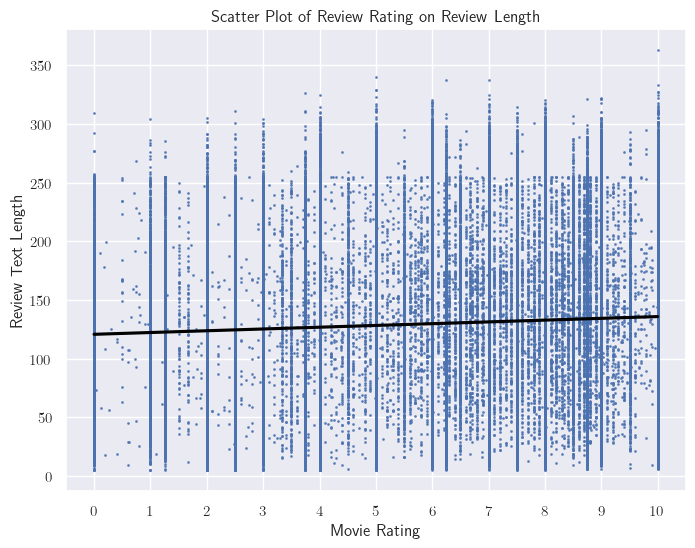

Pearson Correlation: 0.0558


In [22]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_theme(style="darkgrid")

sns.regplot(x=Working_Critic_Data["ratingOutOfTen"], 
            y=Working_Critic_Data["reviewLength"],
            scatter_kws={"s": 1},
            line_kws={"color":"black"},
            ax=ax)

ax.set_title("Scatter Plot of Review Rating on Review Length", fontweight="bold")
ax.set_xticks(range(11))
ax.set_ylabel("Review Text Length")
ax.set_xlabel("Movie Rating")
plt.show()

print("Pearson Correlation:", round(Working_Critic_Data["ratingOutOfTen"].corr(Working_Critic_Data["reviewLength"]), ndigits=4))

### Box Office on Average Critic Rating

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1882/2414301255.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_rating_data = Working_Critic_Data.groupby("id").agg(meanRating = ("ratingOutOfTen", "mean"),


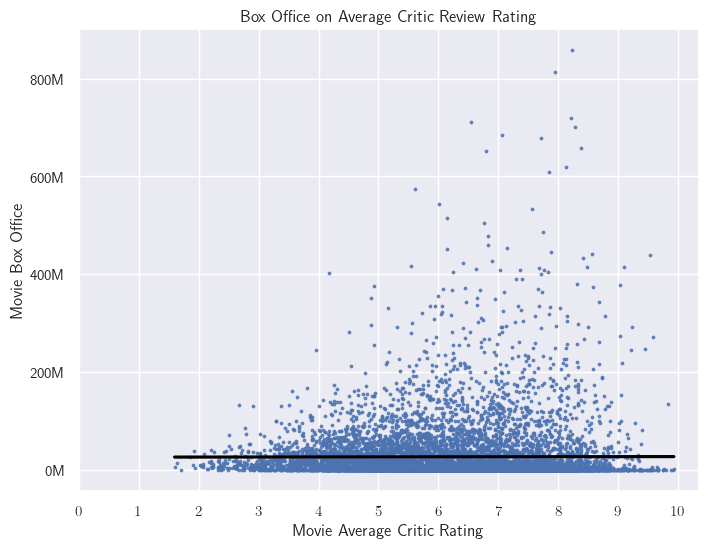

Pearson Correlation Critic Ratings: 0.0029


In [24]:
plot_rating_data = Working_Critic_Data.groupby("id").agg(meanRating = ("ratingOutOfTen", "mean"),
                                                         boxOffice = ("boxOffice", "first")).dropna()             # RatingOutOfTen contains NaNs
fig, ax = plt.subplots(figsize=(8,6))
sns.set_theme(style="darkgrid")

sns.regplot(x=plot_rating_data["meanRating"], 
            y=plot_rating_data["boxOffice"],
            scatter_kws={"s": 3},
            line_kws={"color":"black"},
            ax=ax)

ax.set_title("Box Office on Average Critic Review Rating", fontweight="bold")
ax.set_xlabel("Movie Average Critic Rating")
ax.set_ylabel("Movie Box Office")
ax.set_xticks(range(11))
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
plt.show()

print("Pearson Correlation Critic Ratings:", round(np.corrcoef(
    x=plot_rating_data["meanRating"], 
    y=plot_rating_data["boxOffice"])[0, 1], 4))


### Box Office on Number of Reviews

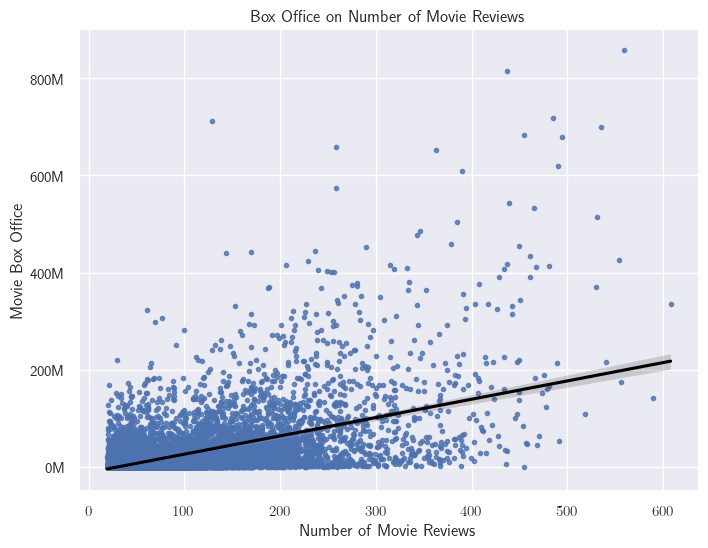

Pearson Correlation: 0.5258


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_theme(style="darkgrid")

sns.regplot(x = Working_Critic_Data["id"].value_counts().sort_index().values, 
            y = Working_Critic_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values,
            marker=".",
            line_kws={"color":"black"},
            ax=ax)

ax.set_title("Box Office on Number of Movie Reviews", fontweight="bold")
ax.set_xlabel("Number of Movie Reviews")
ax.set_ylabel("Movie Box Office")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
plt.show()

print("Pearson Correlation:", round(np.corrcoef(
    x=Working_Critic_Data["id"].value_counts().sort_index().values, 
    y=Working_Critic_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values)[0][1], ndigits=4))

### Box Office on Average Review Text Length

/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1651/2371591770.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.regplot(x = Working_Critic_Data.groupby("id").agg(AvgReviewLen = ("reviewLength", "mean"))["AvgReviewLen"].values,


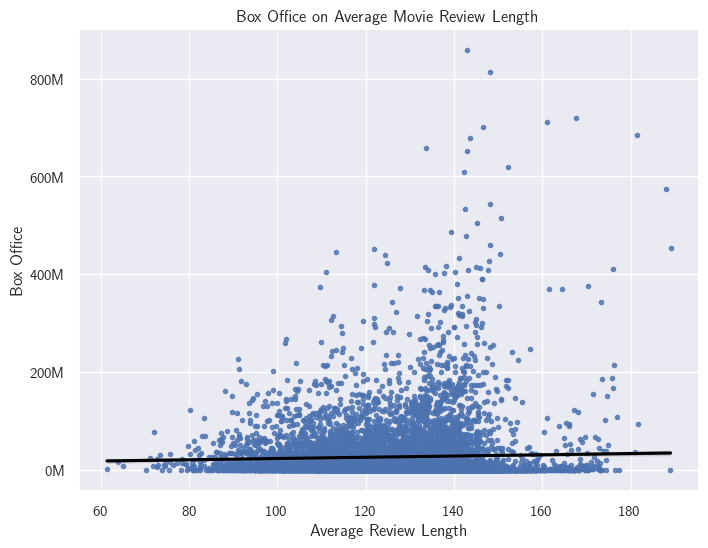

Pearson Correlation: 0.0341


/var/folders/s4/l2x3kbm513b5fgz675t9lszh0000gn/T/ipykernel_1651/2371591770.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  x=Working_Critic_Data.groupby("id").agg(AvgRevLen=("reviewLength", "mean"))["AvgRevLen"].values,


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_theme(style="darkgrid")

sns.regplot(x = Working_Critic_Data.groupby("id").agg(AvgReviewLen = ("reviewLength", "mean"))["AvgReviewLen"].values, 
            y = Working_Critic_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values,
            marker=".",
            line_kws={"color":"black"},
            ax=ax)

ax.set_title("Box Office on Average Movie Review Length", fontweight="bold")
ax.set_xlabel("Average Review Length")
ax.set_ylabel("Box Office")
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x/1000000):,}M".replace(",", "'")))
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", "'")))
plt.show()

print("Pearson Correlation:", round(np.corrcoef(
        x=Working_Critic_Data.groupby("id").agg(AvgRevLen=("reviewLength", "mean"))["AvgRevLen"].values,
        y=Working_Critic_Data[["id", "boxOffice"]].drop_duplicates("id").sort_values("id")["boxOffice"].values)[0, 1], 4))